In [3]:
from qutip import *
import numpy as np
import scipy as sp
import math
import matplotlib.pyplot as plt
from scipy.special import genlaguerre as L

In [4]:
hbar = sp.constants.hbar
h = sp.constants.h
c = sp.constants.c
e = sp.constants.e
eVtoJ = 1.602176634e-19
amutokg = 1.66053906660e-27

omega = 2.0*np.pi*778e3 #Lange
Omegarf = 2.0*np.pi*13e6 #Lange
m = 170.936331517*amutokg
alpha = 5.89e-40 #J m^2 V^-2 E2 transition (Lange)
nu0 = 688358979309307.82 #Hz E2 transition (Huntemann)

In [5]:
def prob(n,nbar):
    return 1.0/(nbar+1)*(nbar/(nbar+1))**n    #returns prob of being in state n given nbar

def dopAndStark(n):       #for 1D!! to make 3d, multiply this by 3                        
    return -2.0*np.pi*nu0*hbar*omega*(n+0.5)/(m*c**2)*(1.0 + alpha*m**2*Omegarf**2*c**2/(h*nu0*e**2*2)) 

def Omega(n,m,eta):
    return np.exp(-eta**2/2.0) * eta**(np.abs(m)) * (math.factorial(n)/math.factorial(n+m))**(np.sign(m)/2.0) \
        * L(n,np.abs(m))(eta**2)              #returns unitless rabi rate of transition n -> n+m given Lamb-Dicke Parameter

In [6]:
def psi(g,e):
    return np.array([g, e])

def pulse(t, Omega0, delta, phi0, phi1):
    Omega = np.sqrt(Omega0**2 + delta**2)
    
    if Omega == 0.0:
        U = np.array([[1.0 , 0.0],
                      [0.0 , 1.0]])
        
    else:
        U = np.array([[np.cos(Omega*t/2.0) -(1.0j*delta/Omega)*np.sin(Omega*t/2.0), (1.0j*Omega0/Omega)*np.sin(Omega*t/2.0)],
                     [(1.0j*Omega0/Omega)*np.sin(Omega*t/2.0) , np.cos(Omega*t/2.0) + (1.0j*delta/Omega)*np.sin(Omega*t/2.0)]])
    
    V1 = np.array([[1.0 , 0.0],
                   [0.0 , np.exp(-1.0j*phi1)]])
    
    V0 = np.array([[1.0 , 0.0],
                   [0.0 , np.exp(1.0j*phi0)]])
    
    return np.exp(1.0j*delta*t/2.0)*V1@U@V0

In [26]:
def densPulse(rho, t, Omega0, delta):
    Omega = np.sqrt(Omega0**2 + delta**2)
    if Omega == 0.0:
        U = np.array([[1.0 , 0.0],
                      [0.0 , 1.0]])
    else:
        U = np.array([[np.cos(Omega*t/2.0) -(1.0j*delta/Omega)*np.sin(Omega*t/2.0), (1.0j*Omega0/Omega)*np.sin(Omega*t/2.0)],
                     [(1.0j*Omega0/Omega)*np.sin(Omega*t/2.0) , np.cos(Omega*t/2.0) + (1.0j*delta/Omega)*np.sin(Omega*t/2.0)]])
    return U@rho@np.conj(U)

def densPhaseInj(rho, phi):
    V = np.array([[1.0 , 0.0],
                   [0.0 , np.exp(1.0j*phi)]])
    return V@rho@np.conj(V)

def thermPulse(rho, t, Omega0, delta, eta):
    Ncut = np.shape(rho)[0]
    result = np.zeros([Ncut,2,2],dtype=np.complex_)
    for n in range(Ncut):
        result[n] = densPulse(rho[n], t, Omega0*Omega(n,0,eta), delta+dopAndStark(n))
    return result

def thermPhaseInj(rho, phi):
    V = np.array([[1.0 , 0.0],
                    [0.0 , np.exp(1.0j*phi)]])
    Ncut = np.shape(rho)[0]
    result = np.zeros([Ncut,2,2],dtype=np.complex_)
    for n in range(Ncut):
        result[n] = V@rho[n]@np.conj(V)
    return result

def heatPulse(rho, t, Omega0, delta, eta, tsteps, nbarDot):
    dt = t/tsteps
    Ncut = np.shape(rho)[0]
    result = np.zeros([Ncut,2,2],dtype=np.complex_)
    result = heatRhoTherm(thermPulse(rho, dt, Omega0, delta, eta), dt, nbarDot)
    for ii in range(tsteps-1):
        result = heatRhoTherm(thermPulse(result, dt, Omega0, delta, eta), dt, nbarDot)
    return result

def heatPulseFast(rho, t, Omega0, delta, eta, tsteps, nbarDot):
    dt = t/tsteps
    Ncut = np.shape(rho)[0]
    result = np.zeros([Ncut,2,2],dtype=np.complex_)
    result = heatRhoTherm(thermPulse(rho, dt, Omega0, delta, eta), dt, nbarDot)
    for ii in range(tsteps-1):
        result = heatRhoTherm(result, dt, nbarDot)
        if ii%100==0: result = thermPulse(result, dt*100.0, Omega0, delta, eta)
    return result

In [8]:
def heatRho(rhon, rhonm, rhonp, dt, n, nbarDot):
    result = np.zeros([2,2],dtype=np.complex_)
    for ii in range(2):
        for jj in range(2):
            result[ii][jj] = rhon[ii][jj] + dt*nbarDot*(-(2.0*n+1)*rhon[ii][jj] + (n+1)*rhonp[ii][jj] + n*rhonm[ii][jj])
    return result

def heatRhoTherm(rho, dt, nbarDot):
    if nbarDot*dt>1e-3: print('nbarDot*dt is too large!!!')
    Ncut = np.shape(rho)[0]
    result = np.zeros([Ncut,2,2],dtype=np.complex_)
    for n in range(Ncut):
        for ii in range(2):
            for jj in range(2):
                if (n==0): result[0][ii][jj] = rho[0][ii][jj] + dt*nbarDot*(-rho[0][ii][jj]+rho[1][ii][jj])
                elif (n==(Ncut-1)): result[Ncut-1][ii][jj] =  rho[Ncut-1][ii][jj] + dt*nbarDot*(-(2.0*Ncut-1)*rho[Ncut-1][ii][jj] + (Ncut-1)*rho[Ncut-2][ii][jj])
                else: result[n][ii][jj] = rho[n][ii][jj] + dt*nbarDot*(-(2.0*n+1)*rho[n][ii][jj] +(n+1)*rho[n+1][ii][jj] +n*rho[n-1][ii][jj])
    return result

In [9]:
def densNbar(rho):
    Ncut = np.shape(rho)[0]
    nbar = 0.0
    for n in range(Ncut):
        nbar += n*(np.real(rho[n][0][0]) + np.real(rho[n][1][1]))
    return nbar

def groundRho(Ncut, nbar):
    rho = np.zeros([Ncut,2,2],dtype=np.complex_)
    for n in range(Ncut):
        rho[n][0][0] = prob(n,nbar)
    return rho

def rhoee(rho):
    Ncut = np.shape(rho)[0]
    result = 0.0
    for n in range(Ncut):
        result += np.real(rho[n][1][1])
    return result
        
def rhogg(rho):
    Ncut = np.shape(rho)[0]
    result = 0.0
    for n in range(Ncut):
        result += np.real(rho[n][0][0])
    return result

In [10]:
def RamseyErrSig(deld, rho0, t1, T, t2, delPrime, Omega0, eta): #, eta, nbar0, nbarf, Ncut, delExc):
    #def thermPulse(rho, t, Omega0, delta, eta):
    intState = thermPulse(thermPulse(rho0, t1, Omega0, delPrime, eta), T, 0.0, deld, eta)
    resultP = thermPulse(thermPhaseInj(intState, np.pi/2.0), t2, Omega0, delPrime, eta)
    resultM = thermPulse(thermPhaseInj(intState, -np.pi/2.0), t2, Omega0, delPrime, eta)
    return rhoee(resultP) - rhoee(resultM)

In [34]:
5/500*nbarDot

0.005

In [27]:
Ncut = 200
nbar = 10.0
rho0 = groundRho(Ncut, nbar)
Omega0 = np.pi/2.0
pts = 20
ts = np.linspace(0.0, 5.0, pts)
#rhoee2s = np.zeros(pts)
nbars = np.zeros(pts)
delta = 0.0*2.0*np.pi
eta = 0.05
tsteps = 1000
nbarDot = 0.1

for ii in range(pts):
    rho = heatPulseFast(rho0, ts[ii], Omega0, delta, eta, tsteps, nbarDot)
    nbars[ii] = densNbar(rho)
    rhoee2s[ii] = rhoee(rho)
    print(nbars[ii])

9.999998894185534
10.026314423733176
10.052630045917141
10.078945684612854
10.105261329125556
10.131576975274237
10.157892620867177
10.184208264549705
10.210523905385648
10.236839542671975
10.26315517584547
10.289470804431135
10.315786428011794
10.342102046208847
10.368417658669797
10.39473326505978
10.421048865055512
10.447364458341008
10.473680044604333
10.499995623535286


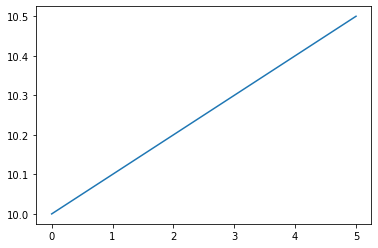

In [28]:
plt.plot(ts,nbars)

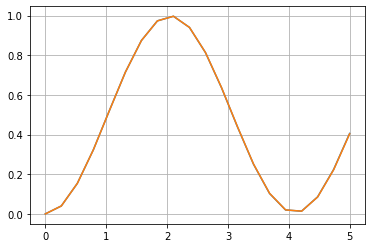

In [29]:
plt.plot(ts, rhoee1s)
plt.plot(ts, rhoee2s)

plt.grid()

In [30]:
100*(rhoee1s[np.size(rhoee1s)-1]-rhoee2s[np.size(rhoee2s)-1])/rhoee1s[np.size(rhoee1s)-1]

0.48797028958156147

In [25]:
100*(rhoee1s[np.size(rhoee1s)-1]-rhoee2s[np.size(rhoee2s)-1])/rhoee1s[np.size(rhoee1s)-1]

0.5142304038295871

In [460]:
Ncut = 200
nbar = 10.0
rho0 = groundRho(Ncut, nbar)
nbarDot = 3.0
pts = 10
ts = np.linspace(0.0, 10.0, pts)
nbars = np.zeros(pts)
for ii in range(pts):
    nbars[ii] = densNbar(heatRhoTherm(rho0, ts[ii], nbarDot))

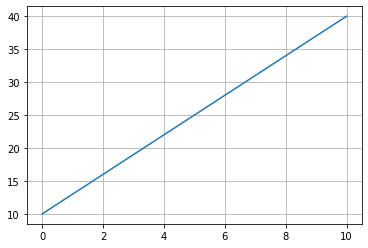

In [461]:
plt.plot(ts, nbars)
plt.grid()

In [258]:
Ncut = 100
nbar = 20.0
rho0 = groundRho(Ncut, nbar)
Omega0 = np.pi/2.0
pts = 20
delPrimes = np.linspace(-0.1*2.0*np.pi, 0.1*2.0*np.pi, pts)
errSigPts = np.zeros(pts)
deld = 0.0
eta = 0.05
t1 = 1.0
T = 20.0
t2 = 1.0
for ii in range(pts):
    errSigPts[ii] = RamseyErrSig(deld, rho0, t1, T, t2, delPrimes[ii], Omega0, eta)

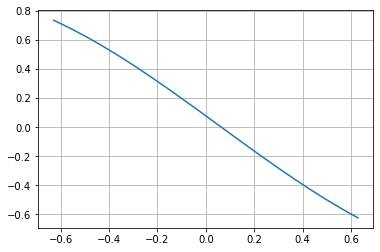

In [259]:
plt.plot(delPrimes, errSigPts)
plt.grid()

In [269]:
Ncut = 100
nbar = 0.0
rho0 = groundRho(Ncut, nbar)
Omega0 = np.pi/2.0
pts = 20
delPrimes = np.linspace(-0.1*2.0*np.pi, 0.1*2.0*np.pi, pts)
shifts2 = np.zeros(pts)
deld = 0.0
eta = 0.0
t1 = 1.0
T = 20.0
t2 = 3.0*t1

tol = 1.0e-11
x0 = -0.1
x1 = 0.1
guessTol = 0.1

for ii in range(pts):
    #print(delPrime[ii]/(2.0*np.pi))
    shifts2[ii] = (1.0/(2.0*np.pi))*sp.optimize.root_scalar(RamseyErrSig, args = (rho0, t1, T, t2, delPrimes[ii], Omega0, eta), bracket=[x0,x1], xtol = tol).root
    x0 = shifts2[ii]*(2.0*np.pi) - guessTol
    x1 = shifts2[ii]*(2.0*np.pi) + guessTol
    #print(shifts[ii])

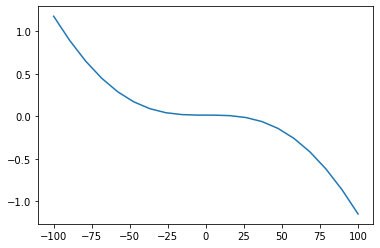

In [271]:
#plt.plot(delPrimes/(2.0*np.pi)*1e3, shifts*1e3)
#plt.plot(delPrimes/(2.0*np.pi)*1e3, shifts1*1e3)
plt.plot(delPrimes/(2.0*np.pi)*1e3, shifts2*1e3)

In [233]:
Ncut = 100
nbar = 20.0
rho0 = groundRho(Ncut, nbar)
pts = 100
ts = np.linspace(0, 10, pts)
Omega0 = 0.0#np.pi/2.0
delta = 0.0
eta = 0.05
rhoees = np.zeros(pts)
for ii in range(pts):
    rhoees[ii] = rhoee(thermPulse(rho0, ts[ii], Omega0, delta, eta))

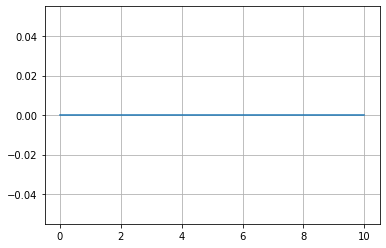

In [234]:
plt.plot(ts, rhoees)
plt.grid()


In [178]:
Ncut = 3
nbar = 0.0
rho = groundRho(Ncut, nbar)
print(rhoee(rho))
print(rhogg(rho))
print(densNbar(rho))
rho = heatRhoTherm(rho, 0.001, 1.0)
print(rhoee(rho))
print(rhogg(rho))
print(densNbar(rho))

0.0
1.0
0.0
0.0
1.0
0.001


In [92]:
t1 = 20e-3
t2 = 3.0*t1
T = 500e-3
rho0 = np.array([[1.0, 0.0],[0.0, 0.0]])
Omega0 = np.pi/(2.0*t1)

pts = 50
delPrime = np.linspace(-0.1*2.0*np.pi, 0.1*2.0*np.pi, pts)
shifts1 = np.zeros(pts)

tol = 1.0e-11
x0 = -0.1
x1 = 0.1
guessTol = 0.1

for ii in range(pts):
    #print(delPrime[ii]/(2.0*np.pi))
    shifts1[ii] = (1.0/(2.0*np.pi))*sp.optimize.root_scalar(RamseyErrSig, args = (rho0, t1, T, t2, delPrime[ii], Omega0), bracket=[x0,x1], xtol = tol).root
    x0 = shifts1[ii]*(2.0*np.pi) - guessTol
    x1 = shifts1[ii]*(2.0*np.pi) + guessTol
    #print(shifts[ii])

-0.1
0.005092942554691748
-0.09591836734693877
0.0048850685467871505
-0.09183673469387756
0.0046771943890834946
-0.08775510204081632
0.004469320087954752
-0.0836734693877551
0.004261445649774907
-0.07959183673469389
0.0040535710809180584
-0.07551020408163266
0.0038456963877584512
-0.07142857142857142
0.0036378215766702127
-0.06734693877551019
0.003429946654027625
-0.06326530612244897
0.003222071626204973
-0.05918367346938776
0.0030141964995765535
-0.055102040816326525
0.0028063212805168815
-0.05102040816326531
0.002598445975400181
-0.046938775510204075
0.0023905705906010753
-0.04285714285714286
0.002182695132493969
-0.038775510204081626
0.0019748196074533377
-0.03469387755102041
0.0017669440218537895
-0.030612244897959186
0.0015590683820698656
-0.026530612244897958
0.0013511926944760645
-0.022448979591836737
0.00114331696544711
-0.018367346938775515
0.0009354412013575801
-0.014285714285714285
0.000727565408582082
-0.010204081632653057
0.000519689593495335
-0.006122448979591827
0.000311

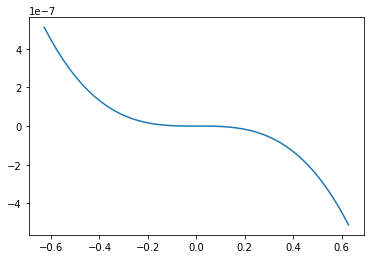

In [95]:
#plt.plot(delPrime, shifts)
plt.plot(delPrime, shifts1)

In [69]:
pts = 100
delds = np.linspace(-2.0*2.0*np.pi, 2.0*2.0*np.pi, pts)
errSigpts = np.zeros(pts)
t1 = 20e-3
t2 = t1
T = 500e-3
rho0 = np.array([[1.0, 0.0],[0.0, 0.0]])
delPrime = 0.5*2.0*np.pi
Omega0 = np.pi/(2.0*t1)
for ii in range(pts):
    errSigpts[ii] = RamseyErrSig(delds[ii], rho0, t1, T, t2, delPrime, Omega0)

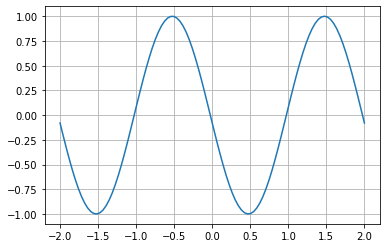

In [70]:
plt.plot(delds/(2.0*np.pi), errSigpts)
plt.grid()

In [84]:
pts = 100
ts = np.linspace(0, 10, pts)
rhoees = np.zeros(pts)
rhoggs = np.zeros(pts)
rho0 = np.array([[1.0, 0.0],[0.0, 0.0]])
Omega0 = np.pi/2.0
delPrime = 0.05*2.0*np.pi
for ii in range(pts):
    rho = densPulse(rho0, ts[ii], Omega0, delPrime)
    rhoees[ii] = np.real(rho[1][1])
    rhoggs[ii] = np.real(rho[0][0])

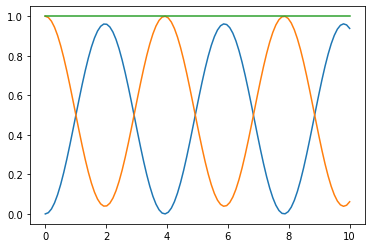

In [85]:
plt.plot(ts, rhoees)
plt.plot(ts, rhoggs)
plt.plot(ts, rhoees+rhoggs)

In [97]:
rho0 = np.array([[1.0, 0.0],[0.0, 0.0]])
Omega0 = np.pi/2.0
t = 1.0
delPrime = 0.01
deld = np.pi/4.0
rho = densPulse(rho0, t, Omega0, delPrime)
rho

array([[ 0.50000435+0.j        , -0.00318307-0.49998987j],
       [-0.00318307+0.49998987j,  0.49999565+0.j        ]])

In [98]:
rho0 = np.array([[1.0, 0.0],[0.0, 0.0]])
Omega0 = np.pi/2.0
t = 1.0
delPrime = 0.01
deld = np.pi/4.0
rho = densPulse(densPulse(rho0, t/2, Omega0, delPrime), t/2, Omega0, delPrime)
rho

array([[ 0.50000435+0.00000000e+00j, -0.00318307-4.99989868e-01j],
       [-0.00318307+4.99989868e-01j,  0.49999565-7.02600974e-21j]])

In [507]:
print(r'$\alpha$')

$\alpha$


In [3]:
20%10

0